In [11]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import operator
import tensorflow as tf
from lime import lime_tabular
from sklearn.preprocessing import MinMaxScaler

from preprocessing import preprocess
from cluster import *
from baseline import train_val_split, baseline_model

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_path = '../labels/'
results_path = '../results/'
clustering_method = 'spectral_clustering'

data_path = '../data/'
course = 'villesafricaines_001'

MODEL_PATH += course + '/'
labels_path += course + '/' + clustering_method + '/'
results_path += course + '/lime/' + clustering_method + '/'


if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
if not os.path.exists(results_path):
    os.makedirs(results_path)

path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
# hard_fail = path + 'feature_labels.csv'
percentile = 0.6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata)

In [13]:
# Concat features & labels
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)Y == 

In [14]:
labels = np.loadtxt(labels_path+'baseline_perc_0.6_gamma_0.6.txt', dtype=int)

In [15]:
def select_instances(model, x, y):
    idx_pass = np.where(y == 0)[0]
    preds_pass = model.predict(x[idx_pass]).flatten()
    i_pass = sorted(range(len(preds_pass)), key=lambda i: preds_pass[i])[-50:]
    instances_pass = [idx_pass[i] for i in i_pass]
    
    idx_fail = np.where(y == 1)[0]
    preds_fail = model.predict(x[idx_fail]).flatten()
    i_fail = sorted(range(len(preds_fail)), key=lambda i: preds_fail[i])[-50:]
    instances_fail = [idx_fail[i] for i in i_fail]
    
    return instances_fail+instances_pass

In [16]:
def get_instance_explanations(c):
    idx = np.where(labels == c)[0]
    X_train = X[idx]
    Y_train = Y[idx]
    x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)

    baseline_params = {
    'name': 'baseline-32u-1l',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['binary_accuracy'],
    'epochs': 20,
    'batch_size': 64,
    'verbose': 1
    }
    baseline = baseline_model()

    baseline.load_weights(MODEL_PATH + 'baseline_classifier_for_cluster_'+str(c)).expect_partial()

    predict_fn = lambda x: np.array([[1-baseline.predict(x)], [baseline.predict(x)]]).reshape(2,-1).T

    explainer = lime_tabular.RecurrentTabularExplainer(x_train, mode='classification',
                                                       class_names=['Pass', 'Fail'], 
                                                       training_labels=y_train, feature_names=feature_names,
                                                        )

    instances = select_instances(baseline, x_train, y_train)

    explainers = []
    for i in instances:
        exp=explainer.explain_instance(x_train[i], predict_fn, num_features=10, labels=(1,))
        explainers.append(exp)
    
    return explainers, instances, y_train

def pyplot_all(explainers, instances, real_labels):
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i, exp in enumerate(explainers):
        l = 'Fail' if real_labels[instances[i]] else 'Pass'
        label = exp.available_labels()[0]
        expl = exp.as_list(label=label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        vals = [x[1] for x in expl]
        names = [x[0] for x in expl]
        
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        pos = np.arange(len(expl)) + .5
        
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if exp.mode == "classification":
            title = 'Local explanation for class %s for instance %d with real class %s' % (exp.class_names[label],instances[i],l)
        plt.title(title)
        plt.show()
        
def DataFrame_all(explainers,instances,real_labels):
    df=pd.DataFrame({})
    class_names=['Pass', 'Fail']
    dfl = []
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i,exp in enumerate(explainers):
        this_label = exp.available_labels()[0]
        l = []
        l.append(("exp number", instances[i]))
        l.append(("real value", 'Fail' if real_labels[instances[i]] else 'Pass'))
        expl = exp.as_list(label=this_label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        l.extend(expl)
        dfl.append(dict(l))
    df = df.append(pd.DataFrame(dfl))
    return df

def preprocess_features(df):
    top_features = []
    for i, s in enumerate(df.columns[2::]):
        if s.split(' ')[0][0].isdigit():
            top_features.append(' '.join(s.split(' ')[2:]))
        else:
            top_features.append(s)
    top_features_type = np.array([s.split('_w-')[0] for s in top_features])
    top_features_week = np.array(['Week_'+s[s.find('_w-')+3::].split(' ')[0] for s in top_features])
    count = (~(df.iloc[:,2::].isnull())).values.sum(axis=0)
    
    top_features_type_unique = list({ k for k in top_features_type })
    count_feature_type = [count[top_features_type==x].sum()/600 for x in top_features_type_unique]
    top_features_week_unique = sorted(list({ k for k in top_features_week }))
    count_feature_week = [count[top_features_week==x].sum()/600 for x in top_features_week_unique]
    return count, top_features_type, top_features_week, top_features_type_unique, count_feature_type, top_features_week_unique, count_feature_week

def get_feature_importance(df, top_features_type_unique, top_features_type):
    feature_type_aggregated = {}
    for i, row in df.iterrows():
        for feature in top_features_type_unique:
            aux = np.nan
            count = 0
            for j in np.where(top_features_type == feature)[0]:
                if np.isnan(row[df.columns[j+2]]):
                    continue
                if np.isnan(aux):
                    aux = 0
                aux += row[df.columns[j+2]]
                count += 1
            if count:
                aux /= count
            try:
                feature_type_aggregated[feature].append(np.absolute(aux))
            except:
                feature_type_aggregated[feature] = []
                feature_type_aggregated[feature].append(np.absolute(aux))
                
    feature_type_mean_importance = {}
    df_aggregated = pd.DataFrame.from_dict(feature_type_aggregated)

    for i in feature_type_aggregated.keys():
        feature_type_mean_importance[i] = np.nanmean(df_aggregated[i])
    return dict(sorted(feature_type_mean_importance.items(), key=operator.itemgetter(1),reverse=True))

In [17]:
for c in np.unique(labels):
    print("Getting explanations for cluster {0}".format(c))
    explainers, instances, real_labels = get_instance_explanations(c)
    df = DataFrame_all(explainers, instances, real_labels)
    df.to_csv(results_path +'lime_cluster_'+str(c)+'.csv')

Getting explanations for cluster 0
Getting explanations for cluster 1
Getting explanations for cluster 2


Cluster 0


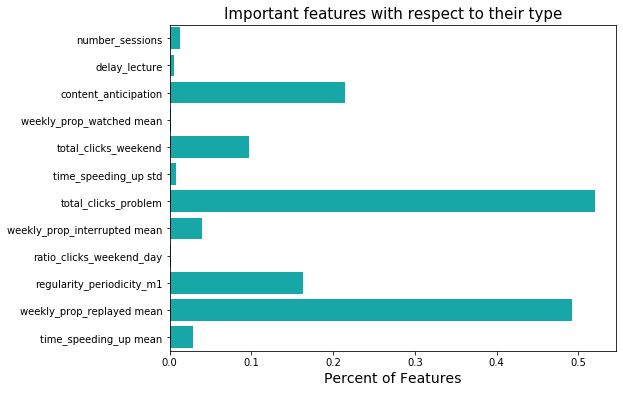

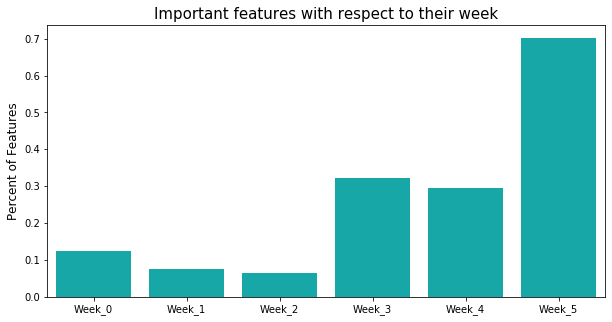

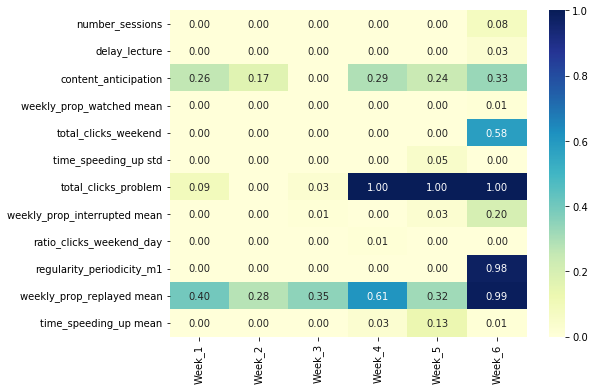

Cluster 1


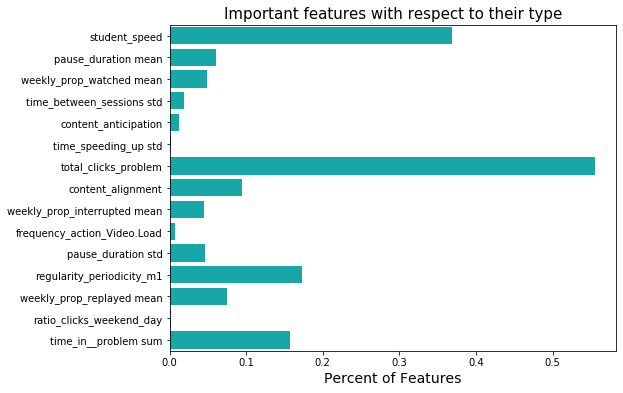

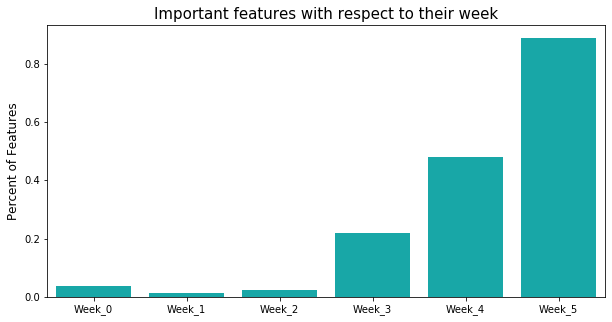

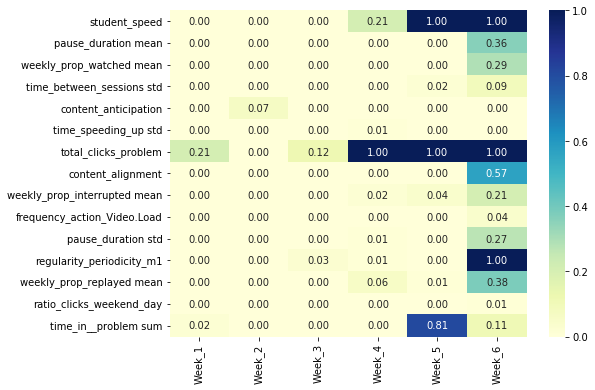

Cluster 2


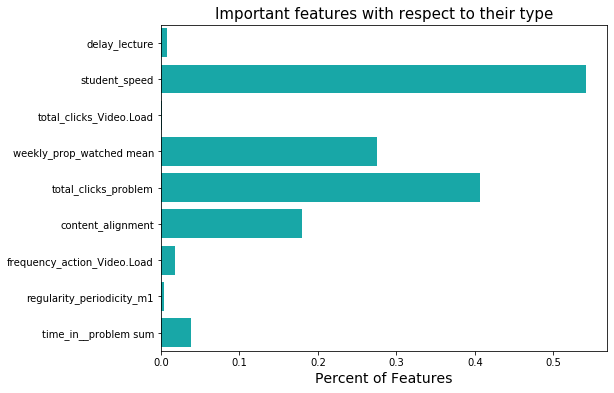

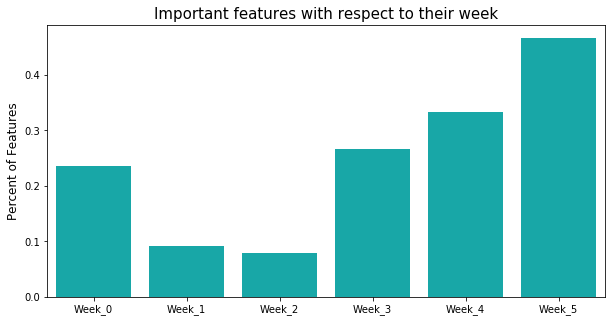

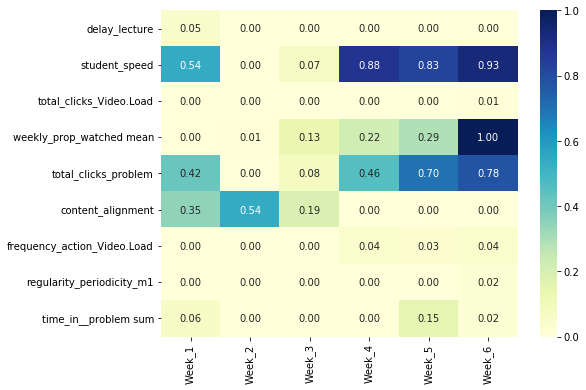

In [18]:
df_importance = pd.DataFrame()
for c in np.unique(labels):
    print("Cluster {0}".format(c))
    df = pd.read_csv(results_path+'lime_cluster_'+str(c)+'.csv', index_col=0)
    count, top_features_type, top_features_week, top_features_type_unique, count_feature_type, top_features_week_unique, count_feature_week = preprocess_features(df)
    
    feature_type_mean_importance = get_feature_importance(df, top_features_type_unique, top_features_type)
    
    aux = pd.DataFrame(feature_type_mean_importance, index=[c])
    df_importance = pd.concat([df_importance, aux])
    
    ind = np.argsort(count_feature_type)[::-1]
    fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
    g = sns.barplot(x=count_feature_type, y= top_features_type_unique, orient = 'h', color='c', ax =ax)
    g.set_title( 'Important features with respect to their type', fontsize=15)
    g.set_xlabel("Percent of Features", fontsize=14)
    plt.show()
    
    ind = np.argsort(count_feature_week)[::-1]
    fig, ax = plt.subplots(figsize=(10, 5),facecolor='white')
    g = sns.barplot(x=top_features_week_unique, y=count_feature_week, color='c',ax =ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=0)
    g.set_title( 'Important features with respect to their week', fontsize=15)
    g.set_xlabel("", fontsize=15)
    g.set_ylabel("Percent of Features", fontsize=12)
    plt.show()
    
    zero_data = np.zeros(shape=(6,len(top_features_type_unique)))
    d = pd.DataFrame(zero_data, columns=top_features_type_unique)
    for i,f in enumerate(top_features_type):
        d[f][int(top_features_week[i].split('_')[1])]+=count[i]
    
    fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
    g = sns.heatmap(d.values.T / len(instances), annot=True, fmt=".2f",ax=ax, cmap="YlGnBu")
    l=list(np.arange(1,6+1))
    g.set_xticklabels(['Week_'+str(i) for i in l],rotation=90)
    g.set_yticklabels(top_features_type_unique,rotation=0)
    plt.show()

In [19]:
df_importance

,total_clicks_problem,weekly_prop_replayed mean,regularity_periodicity_m1,ratio_clicks_weekend_day,total_clicks_weekend,weekly_prop_interrupted mean,content_anticipation,time_speeding_up std,time_speeding_up mean,weekly_prop_watched mean,number_sessions,delay_lecture,student_speed,content_alignment,time_between_sessions std,time_in__problem sum,pause_duration mean,pause_duration std,frequency_action_Video.Load,total_clicks_Video.Load
0,0.147429,0.096768,0.064332,0.058467,0.050666,0.050546,0.048639,0.048594,0.046332,0.045087,0.043941,0.031189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.084378,0.043672,0.074701,0.030690,NaN,0.034157,0.039931,0.042236,NaN,0.037563,NaN,NaN,0.047552,0.038197,0.035908,0.035471,0.033934,0.031873,0.027533,NaN
2,0.052373,NaN,0.046941,NaN,NaN,NaN,NaN,NaN,NaN,0.050406,NaN,0.047582,0.046634,0.047769,NaN,0.055524,NaN,NaN,0.050162,0.042758


In [20]:
df_importance.to_csv(results_path+'features_importance.csv', index=False)